# This notebook is for one off testing of different parameters for various Content, and Style images

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from transfer import CLoss, SLoss, StyleTransfer, StyleTransferLoss

from copy import deepcopy

# Generating Style Transfer Model

### Reading in content and style images

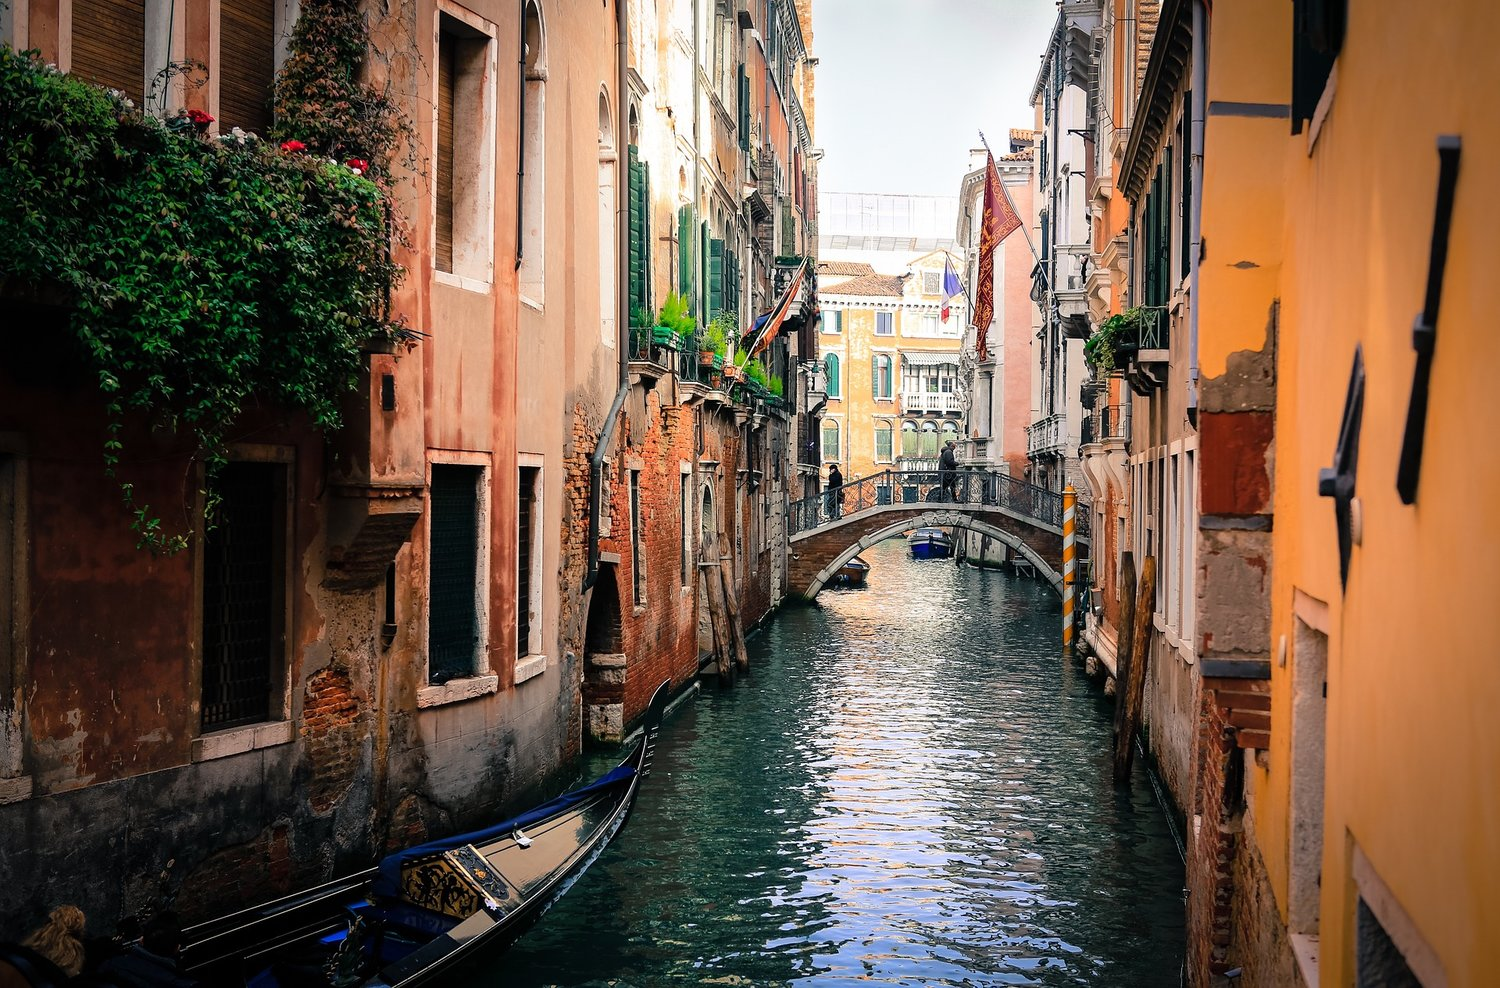

In [2]:
content = Image.open("content-style_image/venice.jpg").convert('RGB')
content

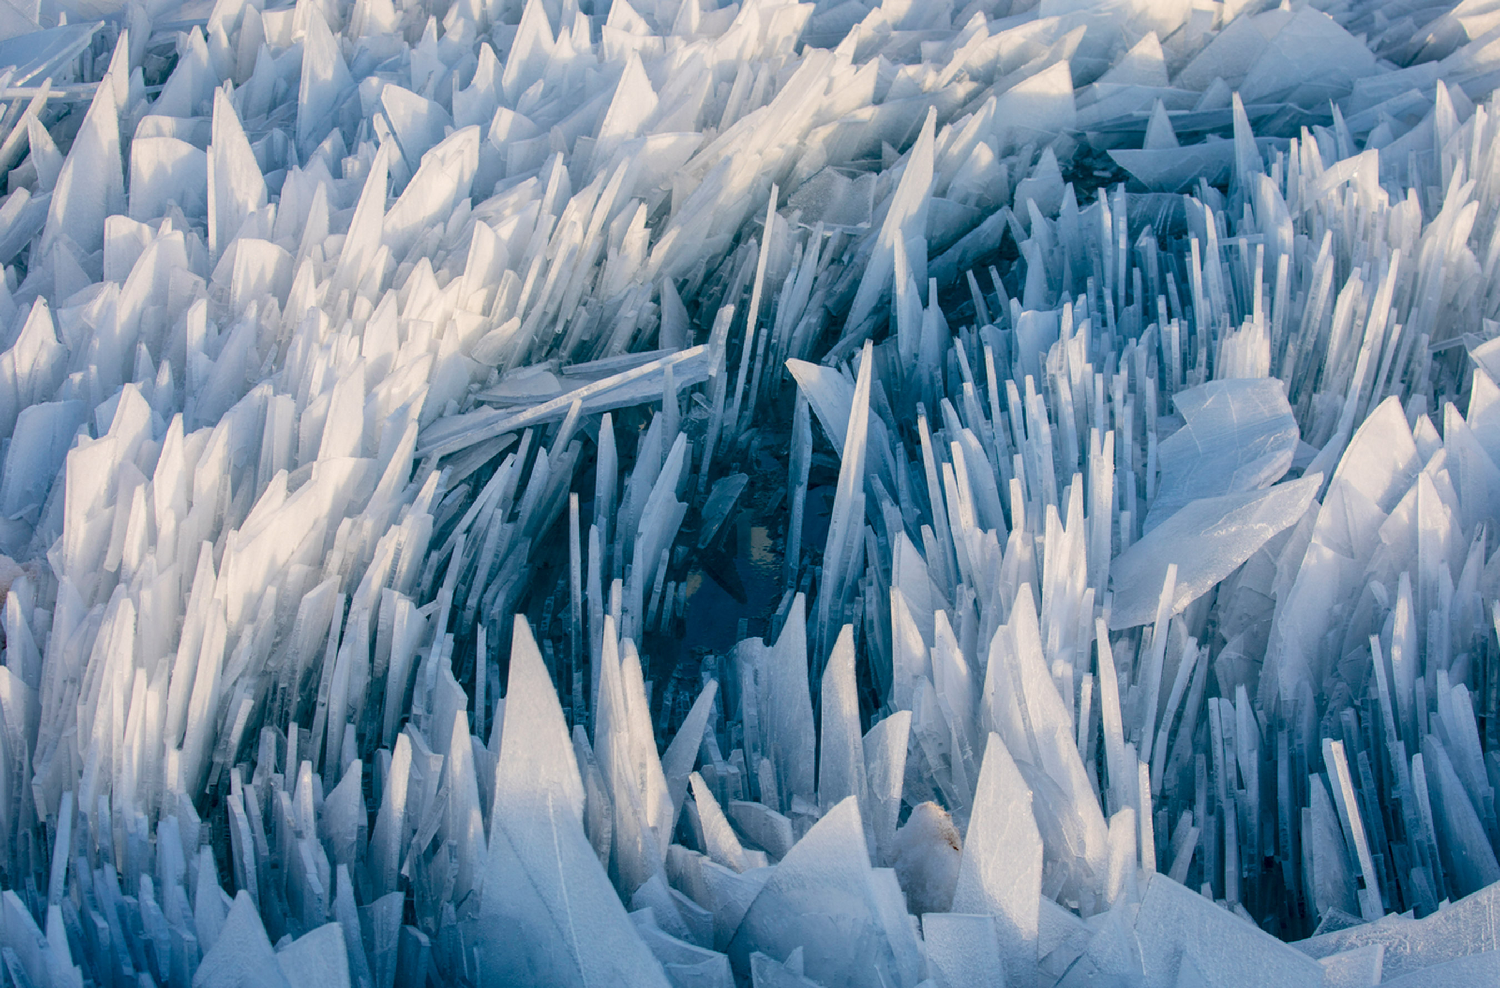

In [3]:
style = Image.open('./content-style_image/lakte-michigan-3.jpg')
style = style.resize(content.size)
style

In [4]:
# Making image transformers
new_size = 600
trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize(new_size),
    torchvision.transforms.ToTensor(),
])

# Making content and style images acceptable for the network.
c = trans(content).unsqueeze(0)
s = trans(style).unsqueeze(0)

# Setting up the base model.
For this case we will be using the convolutional layers of the vgg19 model.

In [5]:
vgg19 = torchvision.models.vgg19(pretrained=True).features.eval()

The model requires the index of the convolution layer. Any layer besides the convolution are not counted while indexing.

In [6]:
vgg19

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [7]:
# Making the network!
transferer = StyleTransfer(vgg19.cuda(), c.cuda(), s.cuda(), content_ixs=[0], style_ixs=[-1], style_weights=[1], alpha=1000, beta=1)
print("Alpha Beta Ration: {}".format(transferer.alpha/transferer.beta))
transferer

Found content!  0
Alpha Beta Ration: 1000.0


StyleTransfer(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (content_loss_0): CLoss()
  )
)

In [8]:
# Content image.
transferer = transferer.cuda()

# Random noise.
var_img = torch.randn(c.shape).cuda().requires_grad_()#

# Making composite loss function for the model.
total_loss = StyleTransferLoss(style_losses=transferer.style_losses, beta=transferer.beta,
                               content_losses=transferer.content_losses, alpha=transferer.alpha)

# Setting up the optimizer.
lr = 1
optimizer = torch.optim.LBFGS([var_img], lr=lr)

# Train the model.
n_epochs = 101

In [9]:
style_losses = []
content_losses = []
total_losses = []
for epoch in range(n_epochs):
    transferer.train()
    def closure():        
        optimizer.zero_grad()

         # Run current image through the model.
        transferer(var_img)

        loss = total_loss()
        
        loss.backward()
        return loss

    optimizer.step(closure)
    
    style_losses.append(transferer.beta*total_loss.style_component)
    content_losses.append(transferer.alpha*total_loss.content_component)
    total_losses.append(transferer.beta*total_loss.style_component + transferer.alpha*total_loss.content_component)
    if epoch%5 == 0:
        # Every 20 iters save a pic.
        print("Epoch: {}, Style Loss: {:6f}, Con Loss: {:6f}".format(epoch, 
                                                                     transferer.beta*total_loss.style_component, 
                                                                     transferer.alpha*total_loss.content_component))
        cpu_img = var_img.cpu()[0, :, :, :]
        cpu_img = torch.clamp(cpu_img, 0, 1)
        cpu_img = torchvision.transforms.ToPILImage()(cpu_img)
        cpu_img.save('./garbage_folder/transfer-loss{}-{}.png'.format(epoch, transferer.beta*total_loss.style_component + transferer.alpha*total_loss.content_component))


Epoch: 0, Style Loss: 0.000000, Con Loss: 0.920154
Epoch: 5, Style Loss: 0.000000, Con Loss: 0.000001
Epoch: 10, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 15, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 20, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 25, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 30, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 35, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 40, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 45, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 50, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 55, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 60, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 65, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 70, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 75, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 80, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 85, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 90, Style Loss: 0.000000, Con Loss: 0.000000
Epoch: 95, Sty

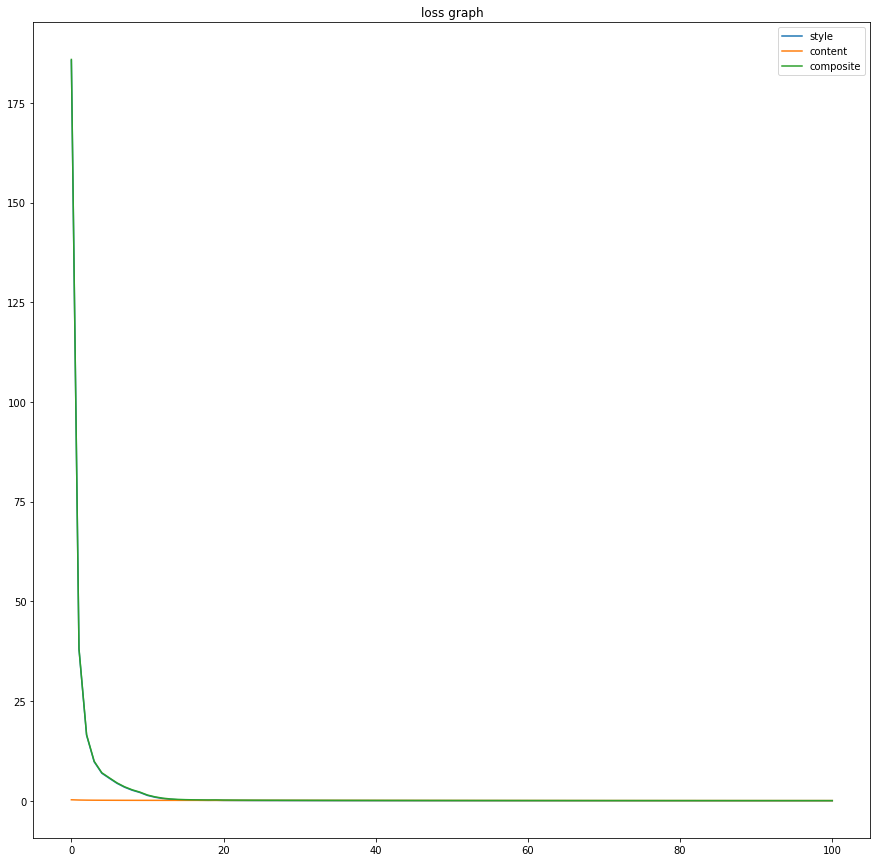

In [10]:
plt.figure(figsize=(15,15))
plt.title("loss graph")
plt.plot(range(n_epochs), style_losses, label='style')
plt.plot(range(n_epochs), content_losses, label='content')
plt.plot(range(n_epochs), total_losses, label='composite')
plt.legend()

***

# Fourway image.

In [ ]:
one = Image.open('transfers_v2/transfer-loss3.864558696746826.png')
two = Image.open('transfers/transfer-loss5.729512691497803.png').resize(one.size)
three = Image.open('transfers_v2/transfer-loss2.5314652919769287.png')
four = Image.open('transfers_v2/transfer-loss18.288883209228516.png')

In [63]:
np.array(one).shape, np.array(two).shape, np.array(three).shape, np.array(four).shape

((600, 600, 3), (600, 600, 3), (600, 600, 3), (600, 600, 3))

In [64]:
new_image = np.zeros((600, 600, 3))

In [71]:
I = np.array(one)[:300, :300]
II = np.array(two)[300:, :300]
III = np.array(three)[:300, 300:]
IIII = np.array(four)[300:, 300:]

new_image[:300, :300] = I
new_image[300:, :300] = II
new_image[:300, 300:] = III
new_image[300:, 300:] = IIII

# WOW!!!!!

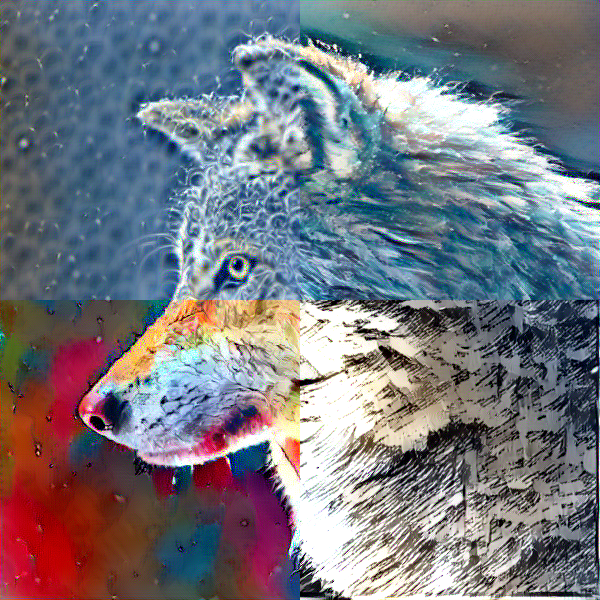

In [72]:
image = Image.fromarray(new_image.astype('uint8'), 'RGB')
image